## TASK 2.2
Development of a classification model for discriminating between 2 classes: benign and malignant diagnosis. Design and development of an ad-hoc CNN architecture(training from scratch).

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%tensorflow_version 2.x
import os
import numpy as np
import tensorflow as tf
import random as rn
from sklearn.metrics import fbeta_score
from skimage import exposure
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import itertools
from tensorflow.compat.v1.keras import backend as K
from tensorflow import keras
import cv2
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Parameters
DIR_PATH = '/content/drive/Shareddrives/Verna_Minutella_Veltroni'
MODEL_PATH = os.path.join(DIR_PATH, 'models/models_task2_2') 
NUMPY_PATH = os.path.join(DIR_PATH, 'numpy_data')

BATCH_SIZE = 64

### Utility function definition

#### Loading training and test sets

In [ ]:
# Loading training set and test set
def load_training():
  images = np.load(os.path.join(NUMPY_PATH,'train_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'train_labels.npy'))
  return images, labels

def load_test():
  images = np.load(os.path.join(NUMPY_PATH,'public_test_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'public_test_labels.npy'))
  return images, labels


#### Printing of confusion matrix

In [ ]:
# function to print the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Specificity : ', specificity )

    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    print('Sensitivity : ', sensitivity)
    plt.show()

#### Plotting the ROC curve

In [ ]:
def plot_roc_curve(probs, test_labels)
  fig2 = plt.figure()
  fpr, tpr, threshold = roc_curve(test_labels, np.rint(probs))
  roc_auc = auc(fpr, tpr) 
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

#### Trend printng of accuracy and loss functions 

In [ ]:
# utility function for plotting accuracy and loss function
def performance_plot(history, model):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  fig1 = plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
  pred_labels = model.predict(test_images)
  pred_labels = np.rint(pred_labels)

  cm = confusion_matrix(test_labels, pred_labels)
  plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')
  #print(confusion_matrix(test_labels, pred_labels))

  print(classification_report(test_labels, pred_labels, digits=4))
  
  plot_roc_curve(pred_labels, test_labels)

#### Seed setting

In [ ]:
# function to set the seed before each execution of the model
def set_seed():
    tf.keras.backend.clear_session()

    seed_num = 1
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_num)
    rn.seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)

#### Model run

In [ ]:
# Function for running different models with different parameters
def run_model(model, model_name, epoch = 100, adam = False, learning_rate = 0.0001):
  if not adam:
    model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
  else:
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['acc'])
    
  model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, model_name+'_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
  callback = EarlyStopping(monitor='val_loss', mode='min', patience=50)

  class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)

  history = model.fit(
    train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=epoch,
    class_weight = dict(enumerate(class_weights)),
    validation_data = validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
    )
  model.save(os.path.join(MODEL_PATH, model_name+'.h5'))
  best_model = models.load_model(os.path.join(MODEL_PATH, model_name+'_best.h5'))

  performance_plot(history, best_model)
 

#### Contrast stretching

In [ ]:
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2,98))
    img_modified = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_modified

### Dataset creation
We take the original dataset with five labels: we discard the label '0', which correspond to baseline patch, because we are considering only the abnormalities, and we aggregate label '1' and '3', which both correspond to *benign*, and label '2' and '4', which are both *malignant*.


In [ ]:
train_img, train_lab = load_training()
test_img, test_lab = load_test()

In [ ]:
# TRAINING SET
abnormality_images = train_img[1::2] 
abnormality_labels = train_lab[1::2]

abnormality_images = abnormality_images.reshape((2676, 150, 150, 1)) 
abnormality_images = abnormality_images.astype('float32') / 65535

# benign
abnormality_labels[abnormality_labels == 1] = 0
abnormality_labels[abnormality_labels == 3] = 0
# malignant
abnormality_labels[abnormality_labels == 2] = 1
abnormality_labels[abnormality_labels == 4] = 1


# VALIDATION SET
train_images, valid_images, train_labels, valid_labels = train_test_split(abnormality_images, abnormality_labels, test_size=0.30, random_state=42, stratify=abnormality_labels)


# TEST SET
test_images = test_img[1::2]
test_labels = test_lab[1::2]

test_images = test_images.reshape((336, 150, 150, 1))
test_images = test_images.astype('float32') / 65535

# benign
test_labels[test_labels == 1] = 0
test_labels[test_labels == 3] = 0
# malignant
test_labels[test_labels == 2] = 1
test_labels[test_labels == 4] = 1


print("Original training set")
print(abnormality_labels.shape)
print(abnormality_images.shape)
print("Training set")
print(train_labels.shape)
print(train_images.shape)
print("Validation set")
print(valid_labels.shape)
print(valid_images.shape)
print("Test set")
print(test_labels.shape)
print(test_images.shape)

Original training set
(2676,)
(2676, 150, 150, 1)
Training set
(1873,)
(1873, 150, 150, 1)
Validation set
(803,)
(803, 150, 150, 1)
Test set
(336,)
(336, 150, 150, 1)


In [ ]:
(unique, counts) = np.unique(train_labels, return_counts=True)
print(unique, counts)

[0 1] [1097  776]


### Preprocessing
We perform Data Augmentation with the training set in order to decrease the possibility to have overfitting. 

We consider geometric transformations, such as the width and height shift, the rotation, the vertical and horizontal flip. We choose as fill mode the default value which fills the area with the nearest pixel and stretching it.


In [ ]:
datagen = ImageDataGenerator()

### Evaluation Metrics for Imbalanced Classification
The dataset is a little bit imbalanced, particularly the training set has 1097 elements from class "benign" and 776 elements from class "malign". 

Considering also the type of classification, it should be noted that misclassifications do not carry the same weight, as a misclassification of a 'malignant' image is more serious than a 'benign' one. For this reason, we decided to evaluate the performance of the following networks not considering the accuracy value but the **F2 score value**, which weights recall higher than precision. This makes this metric more suitable for our problem where it’s more important to classify correctly as many positive samples as possible, rather than maximizing the number of correct classifications.

We also considered the area under the ROC curve as a measure of diagnostic accuracy. For the interpretation of its values, it is possible to refer to the classification proposed by [Swets](http://wixtedlab.ucsd.edu/publications/Psych%20218/Swets_1988.pdf):

1) AUC=0.5 the test is not informative;

2) 0.5<AUC≤0.7 the test is not very accurate;

3) 0.7<AUC≤0.9 the test is moderately accurate;

4) 0.9<AUC<1.0 the test is highly accurate;

5) AUC=1 perfect test.


### Experiment 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5308480   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

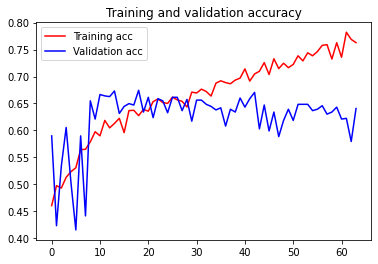

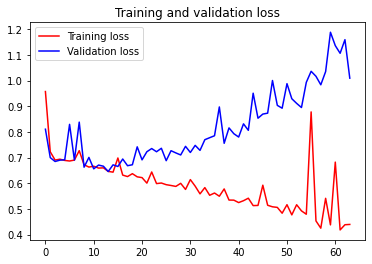

Specificity :  0.8036529680365296
Sensitivity :  0.358974358974359


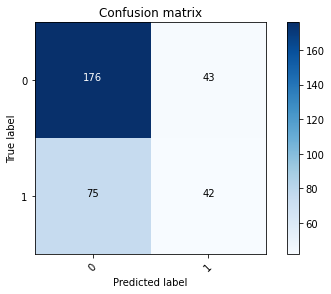

              precision    recall  f1-score   support

           0     0.7012    0.8037    0.7489       219
           1     0.4941    0.3590    0.4158       117

    accuracy                         0.6488       336
   macro avg     0.5977    0.5813    0.5824       336
weighted avg     0.6291    0.6488    0.6329       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


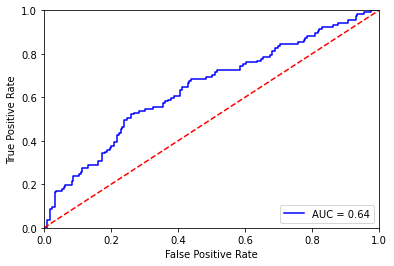

In [ ]:
set_seed()

datagen.fit(train_images)
train_generator = datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

run_model(model, 'model', epoch = 150)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model_best.h5'))
result = model.predict(test_images)
f = fbeta_score(test_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.380


### Experiment 2

In [ ]:
train_datagen = ImageDataGenerator(
    #rotation_range=330,
    rotation_range=180,
    vertical_flip = True,
    horizontal_flip = True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5308480   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

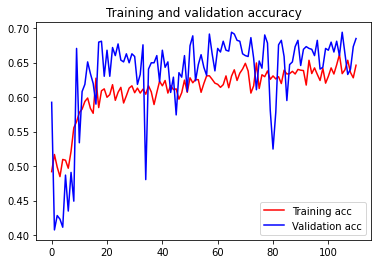

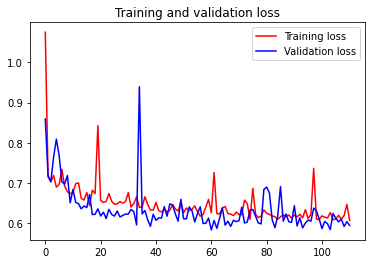

Specificity :  0.6027397260273972
Sensitivity :  0.6239316239316239


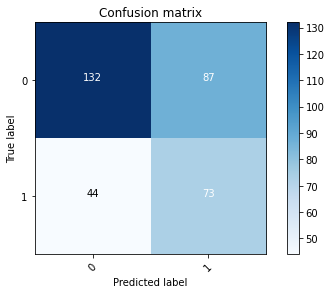

              precision    recall  f1-score   support

           0     0.7500    0.6027    0.6684       219
           1     0.4562    0.6239    0.5271       117

    accuracy                         0.6101       336
   macro avg     0.6031    0.6133    0.5977       336
weighted avg     0.6477    0.6101    0.6192       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


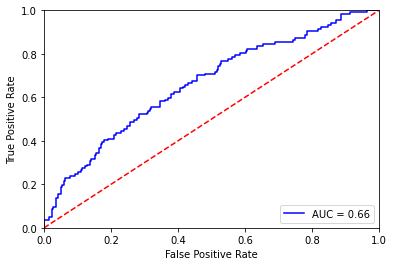

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()

run_model(model2, 'model2', epoch = 150)

In [ ]:
model2 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model2_best.h5'))
result = model2.predict(test_images)
f = fbeta_score(test_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.581


### Experiment 3

aggiungo adam per stabilizzare la stessa rete di prima

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5308480   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

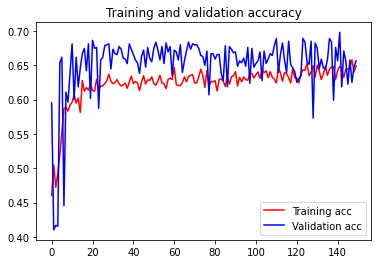

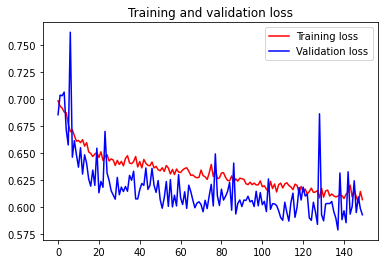

Specificity :  0.589041095890411
Sensitivity :  0.6495726495726496


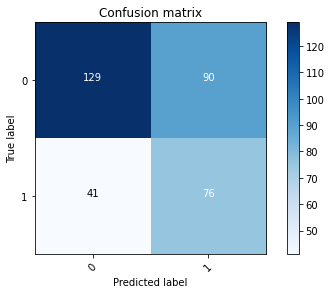

              precision    recall  f1-score   support

           0     0.7588    0.5890    0.6632       219
           1     0.4578    0.6496    0.5371       117

    accuracy                         0.6101       336
   macro avg     0.6083    0.6193    0.6002       336
weighted avg     0.6540    0.6101    0.6193       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


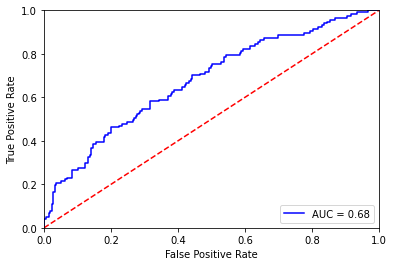

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.summary()

run_model(model3, 'model3', epoch = 150, adam = True, learning_rate = 0.0001)

In [ ]:
model3 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model3_best.h5'))
result = model3.predict(test_images)
f = fbeta_score(test_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.599


### Experiment 4

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

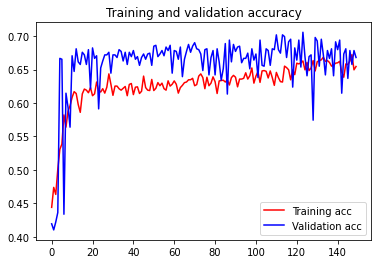

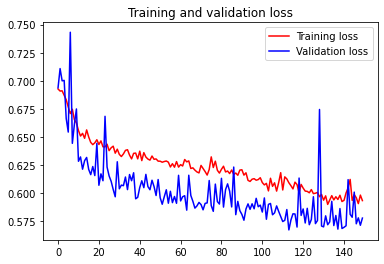

Specificity :  0.6301369863013698
Sensitivity :  0.5897435897435898


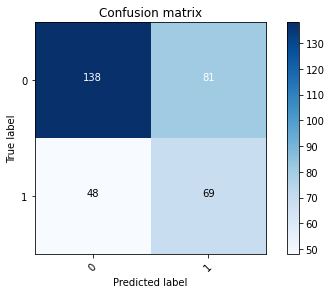

              precision    recall  f1-score   support

           0     0.7419    0.6301    0.6815       219
           1     0.4600    0.5897    0.5169       117

    accuracy                         0.6161       336
   macro avg     0.6010    0.6099    0.5992       336
weighted avg     0.6438    0.6161    0.6242       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


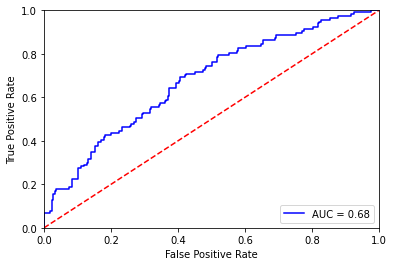

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))
model4.summary()

run_model(model4, 'model4', epoch = 150, adam = True, learning_rate = 0.0001)

In [ ]:
model4 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model4_best.h5'))
result = model4.predict(test_images)
f = fbeta_score(test_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.558


### Experiment 5

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

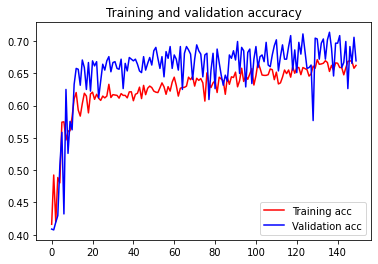

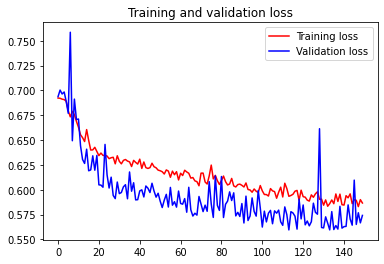

Specificity :  0.639269406392694
Sensitivity :  0.6324786324786325


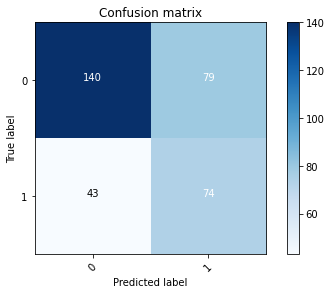

              precision    recall  f1-score   support

           0     0.7650    0.6393    0.6965       219
           1     0.4837    0.6325    0.5481       117

    accuracy                         0.6369       336
   macro avg     0.6243    0.6359    0.6223       336
weighted avg     0.6671    0.6369    0.6449       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


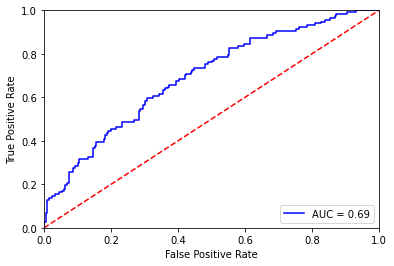

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Flatten())
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))
model5.summary()

run_model(model5, 'model5', epoch = 150, adam = True, learning_rate = 0.0001)

In [ ]:
model5 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model5_best.h5'))
result = model5.predict(test_images)
f = fbeta_score(test_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.596


### Experiment 6

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

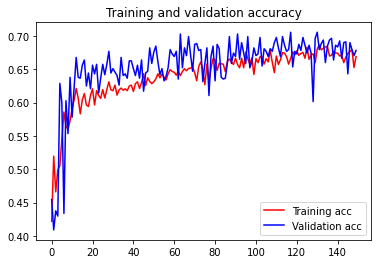

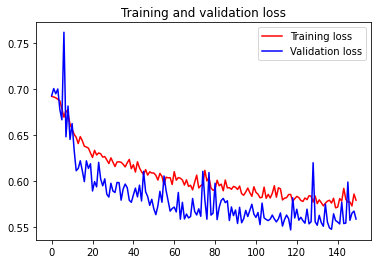

Specificity :  0.6484018264840182
Sensitivity :  0.6666666666666666


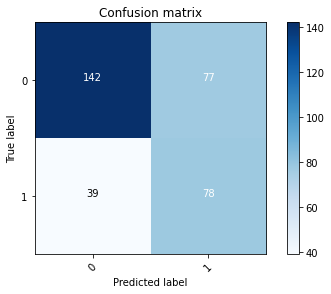

              precision    recall  f1-score   support

           0     0.7845    0.6484    0.7100       219
           1     0.5032    0.6667    0.5735       117

    accuracy                         0.6548       336
   macro avg     0.6439    0.6575    0.6418       336
weighted avg     0.6866    0.6548    0.6625       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


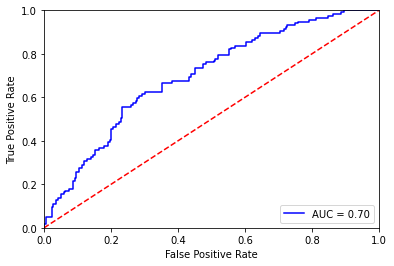

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model6 = models.Sequential()
model6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(256, (3, 3), activation='relu'))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Flatten())
model6.add(layers.Dense(64, activation='relu'))
model6.add(layers.Dense(1, activation='sigmoid'))
model6.summary()

run_model(model6, 'model6', epoch = 150, adam = True, learning_rate = 0.0001)

In [ ]:
model6 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model6_best.h5'))
result = model6.predict(test_images)
f = fbeta_score(test_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.626


### Experiment 7

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

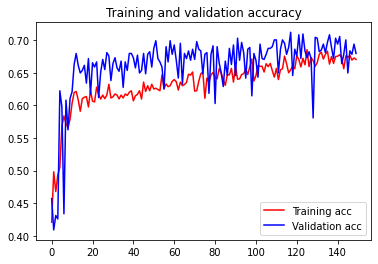

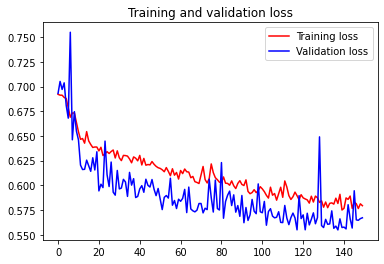

Specificity :  0.5616438356164384
Sensitivity :  0.7350427350427351


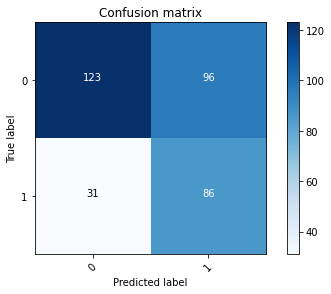

              precision    recall  f1-score   support

           0     0.7987    0.5616    0.6595       219
           1     0.4725    0.7350    0.5753       117

    accuracy                         0.6220       336
   macro avg     0.6356    0.6483    0.6174       336
weighted avg     0.6851    0.6220    0.6302       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


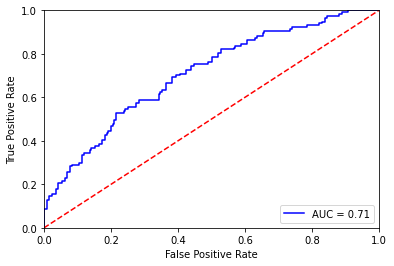

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model7 = models.Sequential()
model7.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Conv2D(64, (3, 3), activation='relu'))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Conv2D(128, (3, 3), activation='relu'))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Conv2D(128, (3, 3), activation='relu'))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Flatten())
model7.add(layers.Dense(128, activation='relu'))
model7.add(layers.Dense(1, activation='sigmoid'))
model7.summary()

run_model(model7, 'model7', epoch = 150, adam = True, learning_rate = 0.0001)

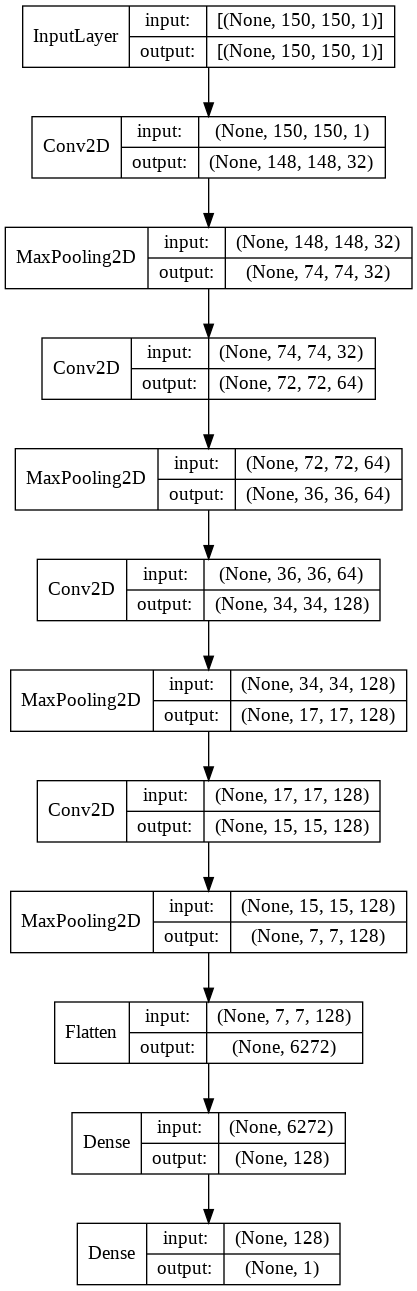

In [ ]:
plot_model(model7, to_file='2_2_architecture.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

In [ ]:
model7 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model7_best.h5'))
result = model7.predict(test_images)
f = fbeta_score(test_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.662


### Experiment 8

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

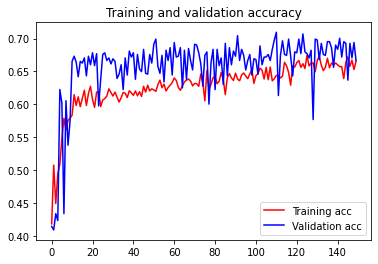

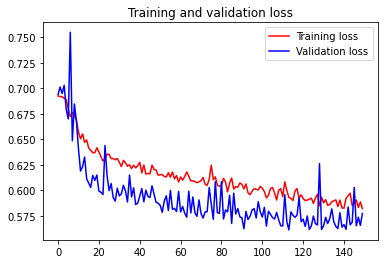

Specificity :  0.6255707762557078
Sensitivity :  0.6239316239316239


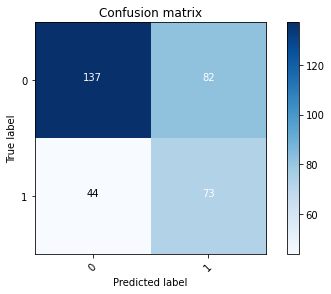

              precision    recall  f1-score   support

           0     0.7569    0.6256    0.6850       219
           1     0.4710    0.6239    0.5368       117

    accuracy                         0.6250       336
   macro avg     0.6139    0.6248    0.6109       336
weighted avg     0.6573    0.6250    0.6334       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


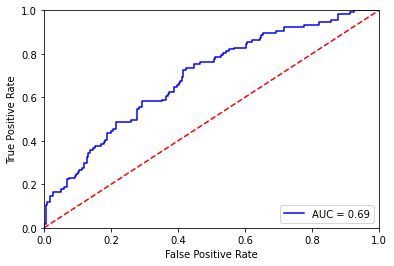

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model8 = models.Sequential()
model8.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(128, (3, 3), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(128, (3, 3), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Flatten())
model8.add(layers.Dense(128, activation='relu'))
model8.add(layers.Dropout(0.3))
model8.add(layers.Dense(1, activation='sigmoid'))
model8.summary()

run_model(model8, 'model8', epoch = 150, adam = True, learning_rate = 0.0001)

In [ ]:
model8 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model8_best.h5'))
result = model8.predict(test_images)
f = fbeta_score(test_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.586


### Experiment 9

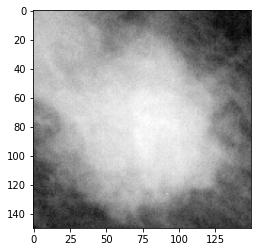

In [ ]:
# plot before increasing contrast
plt.imshow(train_images[0][:,:,0], cmap='gray')
plt.show()

In [ ]:
temp_train = train_images.copy()
for i in train_images:
    i[:,:,0] = contrast_stretching(i[:,:,0])

temp_valid = valid_images.copy()
for i in valid_images:
    i[:,:,0] = contrast_stretching(i[:,:,0])

temp_test = test_images.copy()
for i in test_images:
    i[:,:,0] = contrast_stretching(i[:,:,0])

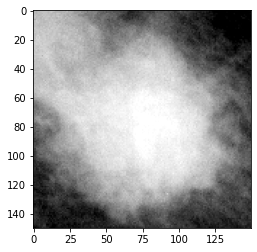

In [ ]:
# plot after increasing contrast
plt.imshow(train_images[0][:,:,0], cmap='gray')
plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

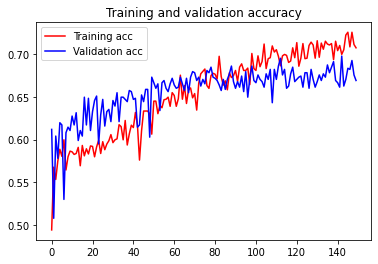

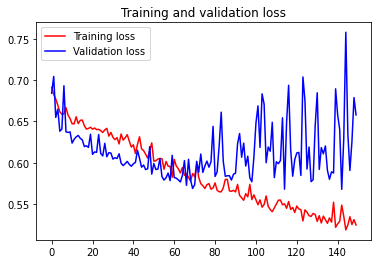

Specificity :  0.6666666666666666
Sensitivity :  0.6239316239316239


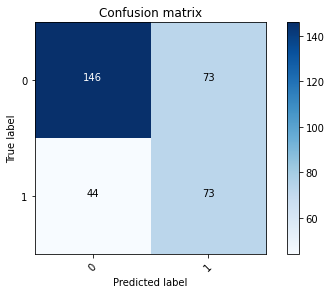

              precision    recall  f1-score   support

           0     0.7684    0.6667    0.7139       219
           1     0.5000    0.6239    0.5551       117

    accuracy                         0.6518       336
   macro avg     0.6342    0.6453    0.6345       336
weighted avg     0.6750    0.6518    0.6586       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


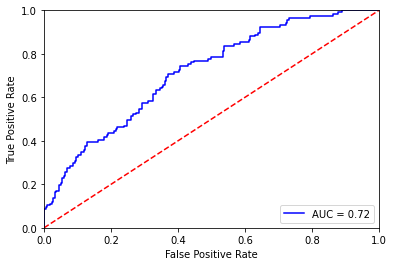

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model7_c = models.Sequential()
model7_c.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model7_c.add(layers.MaxPooling2D((2, 2)))
model7_c.add(layers.Conv2D(64, (3, 3), activation='relu'))
model7_c.add(layers.MaxPooling2D((2, 2)))
model7_c.add(layers.Conv2D(128, (3, 3), activation='relu'))
model7_c.add(layers.MaxPooling2D((2, 2)))
model7_c.add(layers.Conv2D(128, (3, 3), activation='relu'))
model7_c.add(layers.MaxPooling2D((2, 2)))
model7_c.add(layers.Flatten())
model7_c.add(layers.Dense(128, activation='relu'))
model7_c.add(layers.Dense(1, activation='sigmoid'))
model7_c.summary()

run_model(model7_c, 'model7_c', epoch = 150, adam = True, learning_rate = 0.0001)

In [ ]:
model9 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model7_c_best.h5'))
result = model9.predict(test_images)
f = fbeta_score(test_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.424


### Experiment 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

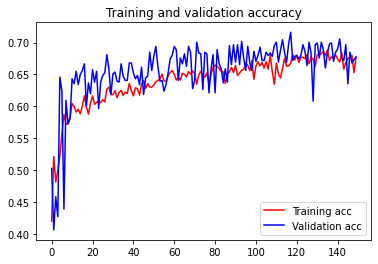

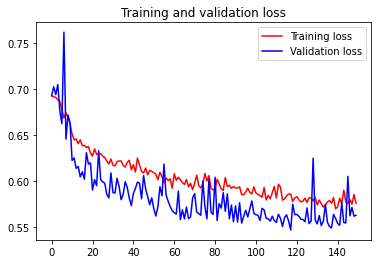

Specificity :  0.6529680365296804
Sensitivity :  0.6410256410256411


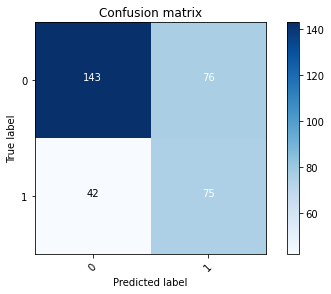

              precision    recall  f1-score   support

           0     0.7730    0.6530    0.7079       219
           1     0.4967    0.6410    0.5597       117

    accuracy                         0.6488       336
   macro avg     0.6348    0.6470    0.6338       336
weighted avg     0.6768    0.6488    0.6563       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


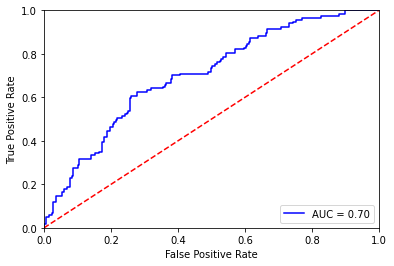

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model10 = models.Sequential()
model10.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Conv2D(64, (3, 3), activation='relu'))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Conv2D(128, (3, 3), activation='relu'))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Conv2D(128, (3, 3), activation='relu'))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Conv2D(256, (3, 3), activation='relu'))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Flatten())
model10.add(layers.Dense(128, activation='relu'))
model10.add(layers.Dense(1, activation='sigmoid'))
model10.summary()

run_model(model10, 'model10.h5', epoch = 150, adam = True, learning_rate = 0.0001)

In [ ]:
model10 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_2/model10.h5_best.h5'))
result = model10.predict(test_images)
f = fbeta_score(test_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.606


### Error analysis

In [ ]:
train_images = temp_train.copy()
valid_images = temp_valid.copy()
test_images = temp_test.copy()

Number of test images: 336
Mispredictions: 31


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


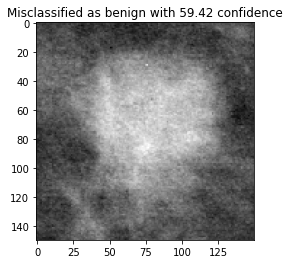

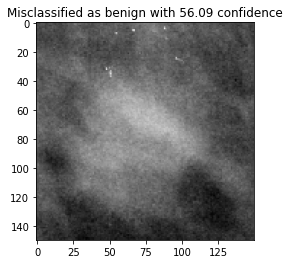

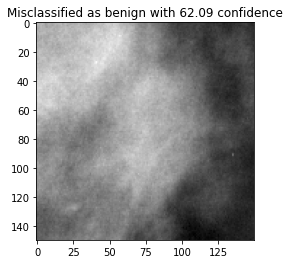

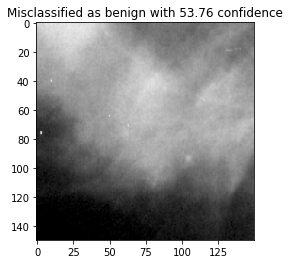

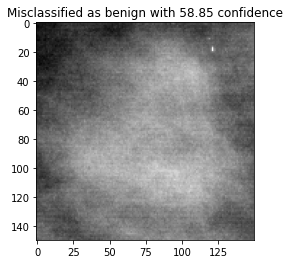

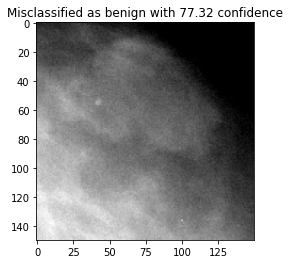

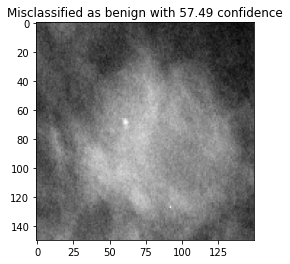

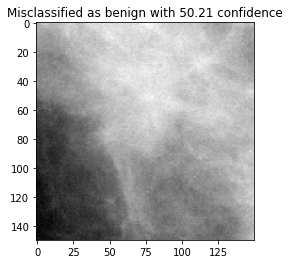

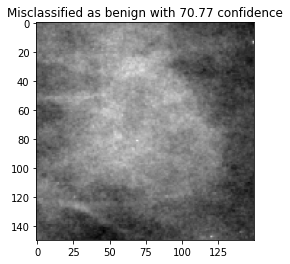

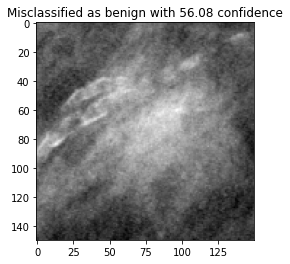

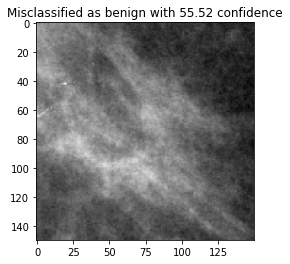

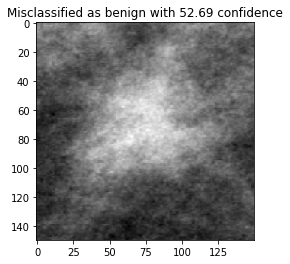

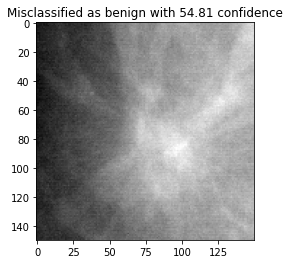

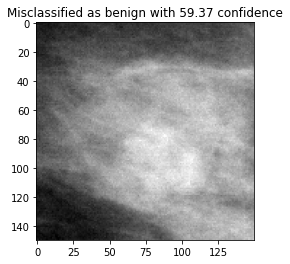

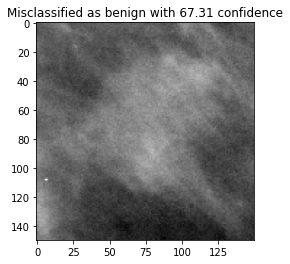

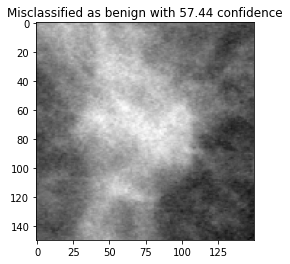

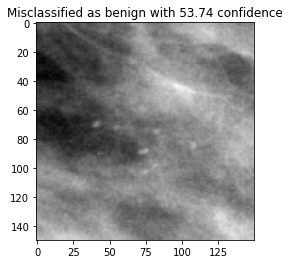

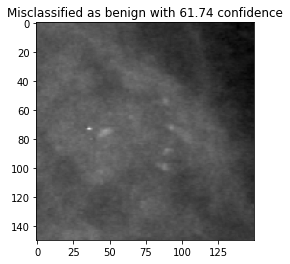

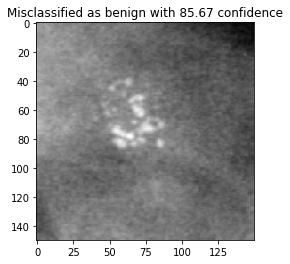

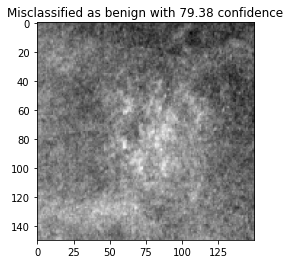

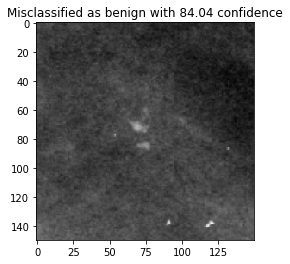

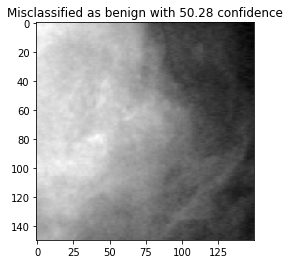

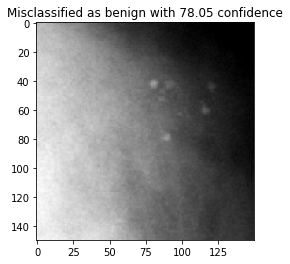

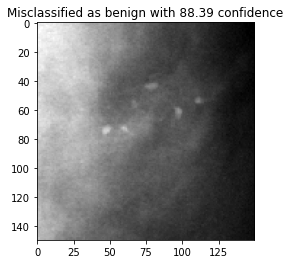

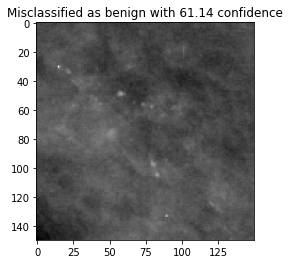

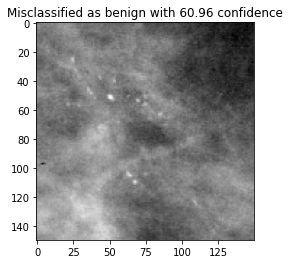

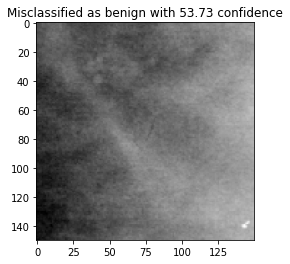

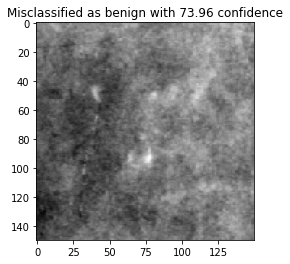

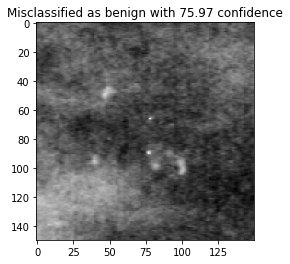

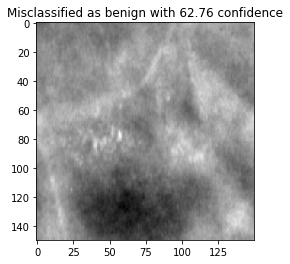

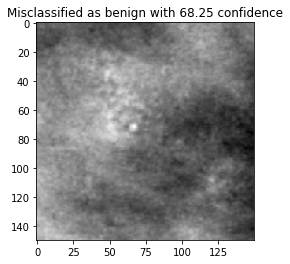

In [ ]:
import seaborn as sns

def get_errors(pred):
    errors = []
    mispred = []

    for label, prediction, img in zip(test_labels, pred, test_images):
        err = abs(label-prediction)
        errors.append(err)
        c = 1 if prediction > 0.5 else 0
        if label == 1 and c== 0 and err > 0.5:
            mispred.append((label,prediction,img))

    return errors, mispred


def show_error_stats(errors, mispred):

    print("Number of test images: %d" % len(test_labels))
    print("Mispredictions: %d" % len(mispred))

    #sns.distplot(errors, kde=False, rug=True, bins=10, vertical=False, label='samples', axlabel='error').set_title('Absolute error distribution');

    for label,prediction,img in mispred:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Misclassified as ' + ('malignant' if label==0 else 'benign') + ' with %.2f confidence' % (100*abs(prediction-label)))
        #plt.axis('off')


opt_model = models.load_model(os.path.join(MODEL_PATH, 'model7_best.h5'))

pred_opt = opt_model.predict(test_images)

errors, mispred = get_errors(pred_opt)


show_error_stats(errors, mispred)